In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text
import concurrent.futures
import pickle
import warnings
from datetime import date
import hisepy
import os
import shutil
warnings.filterwarnings("ignore")
sc.settings.n_jobs = 60
print("Current working directory:", os.getcwd())

Current working directory: /home/jupyter/BRI_Figures_Final_V2/Figure1


In [ ]:

def gen_mpl_labels(adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None, offset=(0.05, 0.05)):
    if adjust_kwargs is None:
        adjust_kwargs = {
            "arrowprops": {"arrowstyle": "->", "color": 'r'}, 
            "expand_points": (1.2, 1.2), 
            "force_points": 0.5
        }
    if text_kwargs is None:
        text_kwargs = {}

    highest_density_points = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        points = adata[g_idx].obsm["X_umap"]
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[50, 50])
        max_bin = np.unravel_index(np.argmax(hist), hist.shape)
        highest_density_point = [
            (xedges[max_bin[0]] + xedges[max_bin[0]+1])/2 + offset[0], 
            (yedges[max_bin[1]] + yedges[max_bin[1]+1])/2 + offset[1]
        ]
        highest_density_points[g] = highest_density_point

    if ax is None:
        ax = plt.gca()

    texts = [
        ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in highest_density_points.items()
    ]

    adjust_text(texts, **adjust_kwargs)


# Download files

### reference

In [3]:
input_uuid=["d316b20b-f24b-46e7-b6a1-225ca9996991"]


In [19]:
hise_res = hisepy.reader.cache_files(input_uuid)

In [ ]:
destination_dir=os.getcwd()+"/reference/"

In [21]:
for i in input_uuid:
    source_dir='/home/jupyter/cache/'+i
    files = os.listdir(source_dir)
    shutil.move(os.path.join(source_dir), destination_dir)

In [5]:
%%time
os.listdir(destination_dir)

CPU times: user 519 µs, sys: 161 µs, total: 680 µs
Wall time: 496 µs


['ref_clean_pbmc_labeled_2024-04-18.h5ad']

# Reperform UMAP

In [3]:
adata=sc.read_h5ad('reference/ref_clean_pbmc_labeled_2024-04-18.h5ad')
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

mask = ~adata.var_names.isin(exl_genes)
adata = adata[:, mask]

In [5]:
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]

In [6]:
%%time
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca', n_pcs=30)

CPU times: user 1h 56min 7s, sys: 32min 37s, total: 2h 28min 45s
Wall time: 15min 41s


In [ ]:
%%time
sc.tl.umap(adata,min_dist=0.45,random_state=0)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [ ]:
adata=adata.raw.to_adata()
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.write_h5ad('reference/AIFI_Ref_reprocessed.h5ad')

# Plotting

In [3]:
adata=sc.read_h5ad('reference/AIFI_Ref_reprocessed.h5ad')

In [4]:
print(adata.obs['AIFI_L1'].nunique())
print(adata.obs['AIFI_L2'].nunique())
print(adata.obs['AIFI_L3'].nunique())

9
29
71


In [5]:
print(adata.obs['AIFI_L1'].value_counts())
print(adata.obs['AIFI_L2'].value_counts())
print(adata.obs['AIFI_L3'].value_counts())

AIFI_L1
T cell             1150345
Monocyte            327919
B cell              160632
NK cell             147761
DC                   23287
Platelet              7903
Progenitor cell       1526
Erythrocyte           1508
ILC                    844
Name: count, dtype: int64
AIFI_L2
Naive CD4 T cell         378071
Memory CD4 T cell        321788
CD14 monocyte            269328
Memory CD8 T cell        183096
CD56dim NK cell          133881
Naive CD8 T cell         121167
Naive B cell              86711
gdT                       50587
Memory B cell             47886
MAIT                      46143
CD16 monocyte             45920
Treg                      39087
cDC2                      14235
Intermediate monocyte     12671
Transitional B cell       12555
Effector B cell           11329
CD56bright NK cell        11055
Platelet                   7903
pDC                        7587
CD8aa                      5737
Proliferating NK cell      2825
DN T cell                  2349
Proliferati

In [6]:
adata.obs.index=adata.obs['barcodes']

In [7]:
colors=pd.read_csv('/home/jupyter/BRI_Figures/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_dict=dict(zip(colors.label, colors.color))

NameError: name 'gen_mpl_labels' is not defined

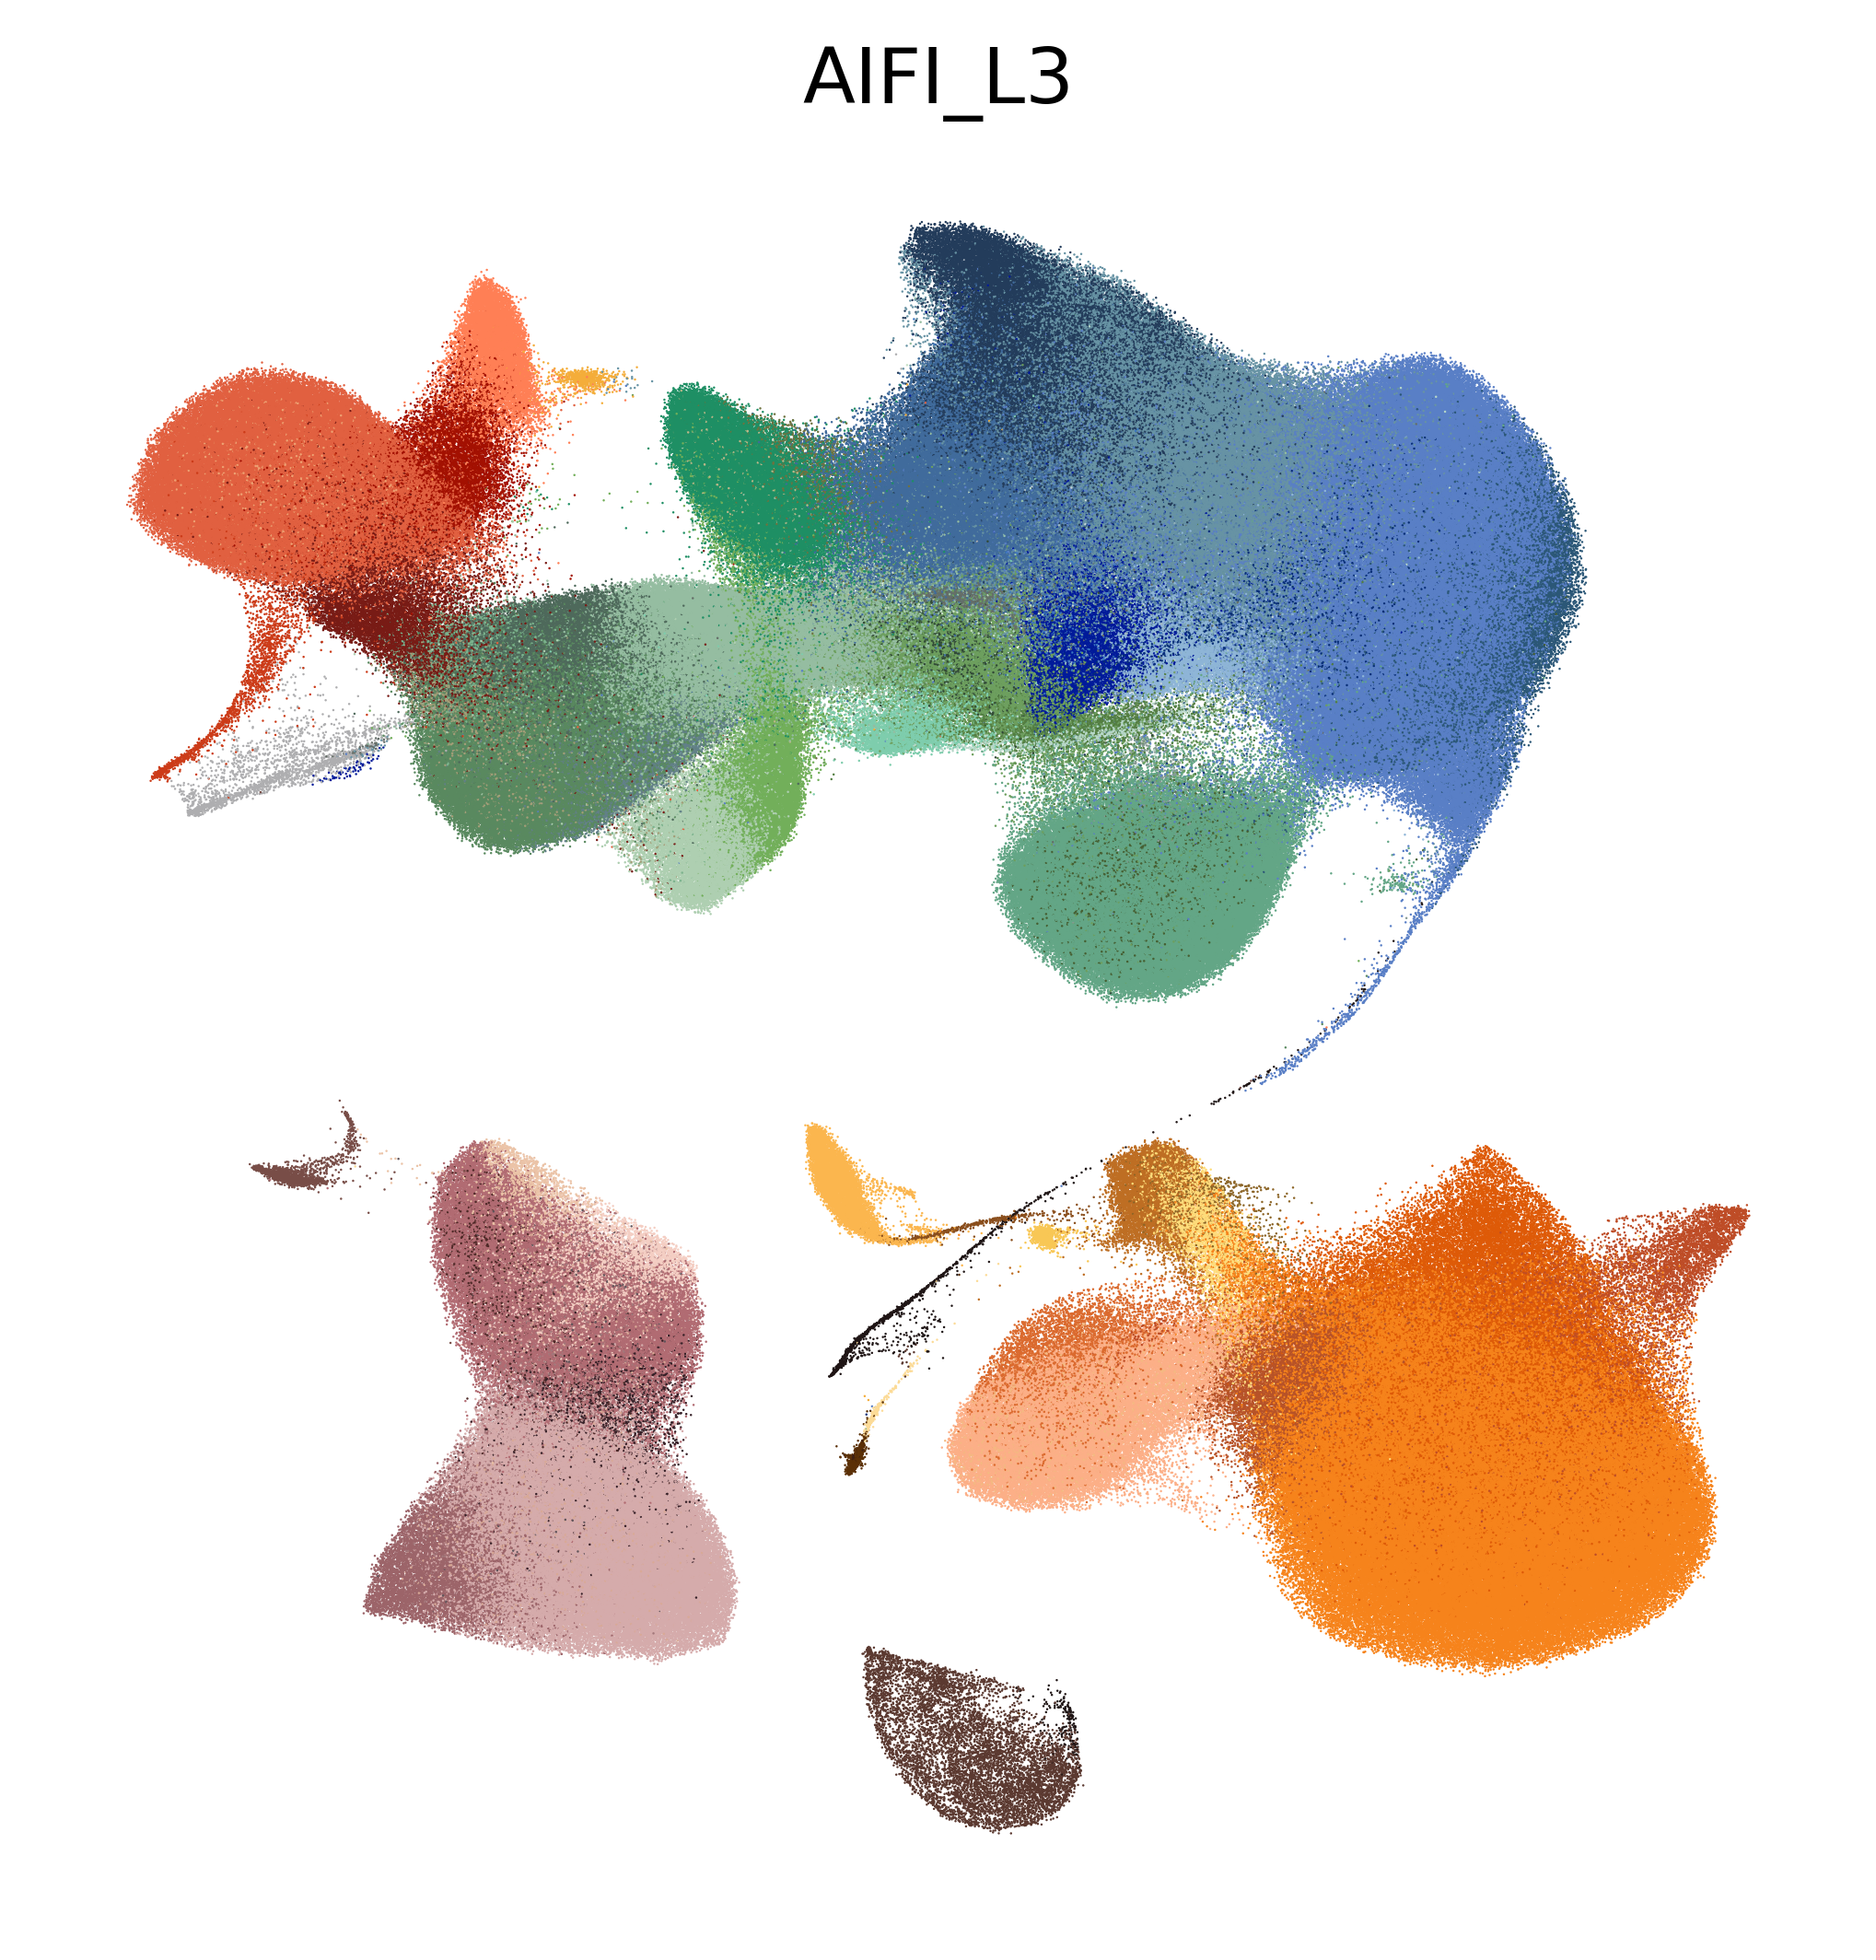

In [8]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 500, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L3'], size=0.5,show=False,legend_loc=None,ncols=1,palette=color_dict,frameon=False)
    gen_mpl_labels(
        adata,
        "AIFI_L3",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=5),)
    fig = ax.get_figure()
    fig.tight_layout()

In [ ]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 300, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['AIFI_L3'], size=0.5,show=False,ncols=1 ,palette=color_dict,frameon=False)
    fig = ax.get_figure()
    fig.tight_layout()

In [ ]:
%%time
milo.make_nhoods(adata)
milo.count_nhoods(adata, sample_col="pbmc_sample_id")

In [ ]:
adata.write_h5ad('reference/AIFI_Ref_reprocessed_milo.h5ad')